In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pandas import Series
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from livelossplot import PlotLossesKeras
import tensorflow_addons as tfa


In [2]:

X_Numerical = pd.read_csv("C:\\Users\\mimus\\Documents\\curso_deep_learning\\data\\BTC_OHLC.csv")


X_Numerical.sort_values('timestamp', inplace=True)
X_Numerical=X_Numerical.reset_index(drop=True)


X_Numerical=X_Numerical.set_index("timestamp")
X_Numerical

,open,high,low,close
timestamp,,,,
1546323300,3691.5,3691.5,3691.0,3691.5
1546323600,3691.5,3691.5,3691.0,3691.0
1546323900,3691.0,3691.5,3688.5,3689.0
1546324200,3689.0,3690.5,3689.0,3690.5
1546324500,3690.5,3691.0,3690.0,3690.5
...,...,...,...,...
1656024000,21066.0,21108.5,21050.5,21068.0
1656024300,21068.0,21148.0,21053.0,21085.0
1656024600,21085.0,21085.5,20962.0,20967.0


In [3]:
X_Numerical.columns

Index(['open', 'high', 'low', 'close'], dtype='object')

In [4]:
X_Numerical['pct_change'] = X_Numerical.close.pct_change()
X_Numerical['log_ret'] = np.log(X_Numerical.close) - np.log(X_Numerical.close.shift(1))
X_Numerical["sdev"] = X_Numerical.log_ret.rolling(window=60).std()
X_Numerical=X_Numerical.iloc[60:]


In [5]:
cols = ['open', 'high', 'low', 'close',"log_ret", "sdev"]
X_Numerical=X_Numerical[cols]

In [6]:
'''Create indexes to split dataset'''

times = sorted(X_Numerical.index.values)
last_10pct = sorted(X_Numerical.index.values)[-int(0.02*len(times))] # Last 10% of series
last_20pct = sorted(X_Numerical.index.values)[-int(0.05*len(times))] # Last 20% of series

scaler = MinMaxScaler(feature_range=(0, 1))

data = X_Numerical.open.to_list()
series = Series(data)
values = series.values
values = values.reshape((len(values), 1))
scaler_open = scaler.fit(values)
X_Numerical["open"] = scaler_open.transform(values)                

data = X_Numerical.high.to_list()
series = Series(data)
values = series.values
values = values.reshape((len(values), 1))
scaler_high = scaler.fit(values)
X_Numerical["high"] = scaler_high.transform(values)                         
                                          
data = X_Numerical.low.to_list()
series = Series(data)
values = series.values
values = values.reshape((len(values), 1))
scaler_low = scaler.fit(values)
X_Numerical["low"] = scaler_low.transform(values)                         
                                          
data = X_Numerical.close.to_list()
series = Series(data)
values = series.values
values = values.reshape((len(values), 1))
scaler_close = scaler.fit(values)
X_Numerical["close"] = scaler_close.transform(values)                         
                                          

data = X_Numerical.log_ret.to_list()
series = Series(data)
values = series.values
values = values.reshape((len(values), 1))
scaler_log_ret = scaler.fit(values)
X_Numerical["log_ret"] = scaler_log_ret.transform(values)  

data = X_Numerical.sdev.to_list()
series = Series(data)
values = series.values
values = values.reshape((len(values), 1))
scaler_sdev = scaler.fit(values)
X_Numerical["sdev"] = scaler_sdev.transform(values)         

In [7]:
train_num = X_Numerical[(X_Numerical.index < last_20pct)]  # Training data are 80% of total data
val_num = X_Numerical[(X_Numerical.index >= last_20pct) & (X_Numerical.index < last_10pct)]
test_num = X_Numerical[(X_Numerical.index >= last_10pct)]


# Convert pandas columns into arrays
train_num = train_num.values
val_num = val_num.values
test_num = test_num.values
print('Training data shape: {}'.format(train_num.shape))
print('Validation data shape: {}'.format(val_num.shape))
print('Test data shape: {}'.format(test_num.shape))



Training data shape: (347320, 6)
Validation data shape: (10968, 6)
Test data shape: (7311, 6)


In [8]:
batch_size =512
seq_len = 32#aaron premise <= 3



In [9]:
# Training data#aqui debemos de poner el img paths#######hay que modificar esto para qeu no tengamos que setear cual es la y, por ejemplo como el y se agarra del futuro podemos dejar esa columna en la data de train

XN_train,   y_train = [],[]
for i in range(seq_len, len(train_num)):
    XN_train.append(train_num[i-seq_len:i])# Chunks of training data with a length of 128 df-rows
    
    y_train.append(train_num[:, -1][i]) #Value of 4th column (Close Price) of df-row 128+1
XN_train,  y_train = np.array(XN_train), np.array(y_train)

###############################################################################

# Validation data
XN_val, y_val = [], []
for i in range(seq_len, len(val_num)):
    XN_val.append(val_num[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows

    y_val.append(val_num[:, -1][i]) #Value of 4th column (Close Price) of df-row 128+1######revisar si esto esta bien con el +1 o si es doble con el shift -1
XN_val,  y_val = np.array(XN_val), np.array(y_val)


###############################################################################

# Test data
XN_test, y_test = [],[]
for i in range(seq_len, len(test_num)):
    XN_test.append(test_num[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows

    y_test.append(test_num[:, -1][i]) #Value of 4th column (Close Price) of df-row 128+1######revisar si esto esta bien con el +1 o si es doble con el shift -1
XN_test,  y_test = np.array(XN_test), np.array(y_test)


In [10]:
XN_test.shape

(7279, 32, 6)

In [11]:
df = pd.DataFrame({'x_nums':list(XN_train)})


def dataset_gen(df,positions,batch_size):
    x_numerical = tf.constant([np.array(x) for x in df.x_nums.values]) 
    train_dataset = tf.data.Dataset.from_tensor_slices((x_numerical, positions))
    train_dataset = train_dataset.batch(batch_size)
    return train_dataset
train_data = dataset_gen(df,y_train,batch_size)

df = pd.DataFrame({'x_nums':list(XN_val)})

val_data = dataset_gen(df,y_val,batch_size)

#df = pd.DataFrame({'x_nums':list(XN_test)})
#test_data = dataset_gen(df,y_test,batch_size)

In [12]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = x[:,:,3]
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config
  

In [13]:
plotlosses = PlotLossesKeras()
XN_train.shape,y_train.shape


((347288, 32, 6), (347288,))

In [17]:
plotlosses = PlotLossesKeras()
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(32,3,input_shape=(32,6,)),
  tf.keras.layers.MaxPooling1D(2),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss=["mae"], 
                  optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
                  metrics=["mae"])

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
                                              monitor='val_mae', save_best_only=True, verbose=1)

  

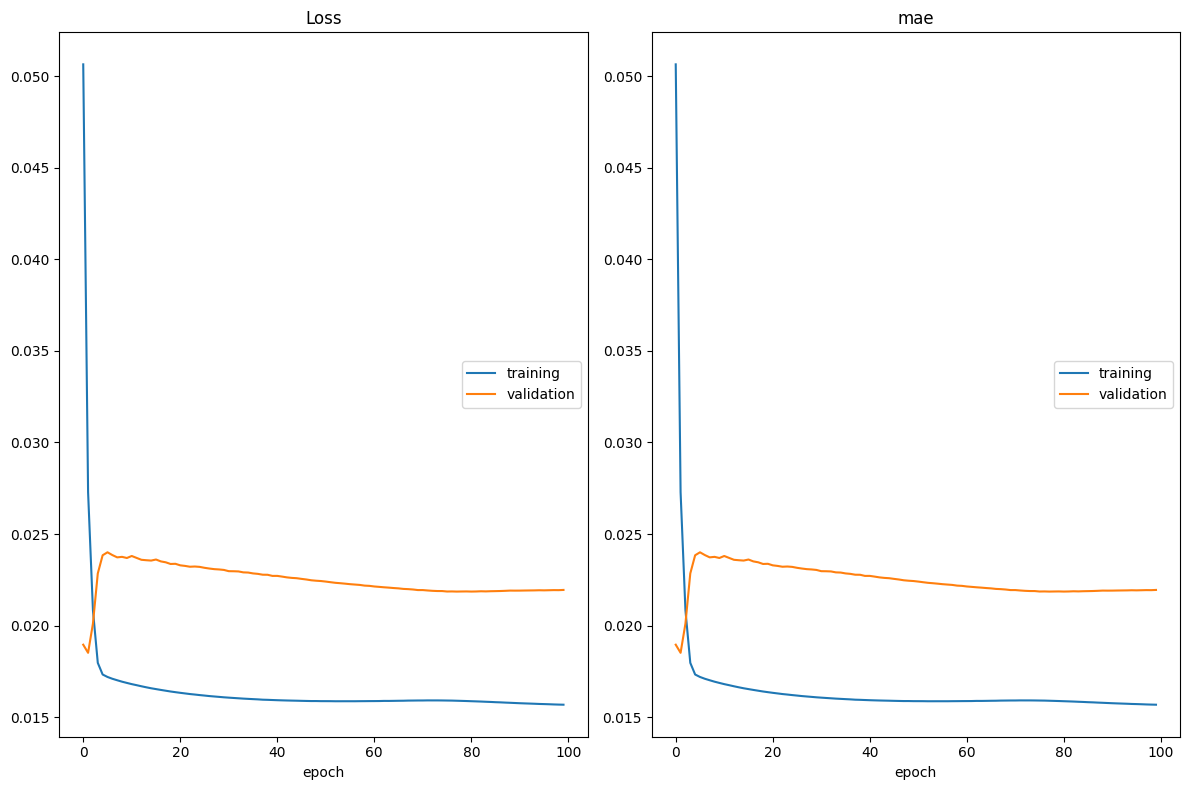

Loss
	training         	 (min:    0.016, max:    0.051, cur:    0.016)
	validation       	 (min:    0.019, max:    0.024, cur:    0.022)
mae
	training         	 (min:    0.016, max:    0.051, cur:    0.016)
	validation       	 (min:    0.019, max:    0.024, cur:    0.022)

Epoch 100: val_mae did not improve from 0.01852
679/679 [==============================] - 5s 7ms/step - loss: 0.0157 - mae: 0.0157 - val_loss: 0.0219 - val_mae: 0.0219


In [18]:

history = model.fit(train_data,
                        batch_size=batch_size,
                        epochs=100,
                        shuffle=False,
                        callbacks=[plotlosses,callback],
                        validation_data=val_data
                       )